# Numpy, la brique de base

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Les ufuncs

[Les `ufuncs` (pour **u**niversal **func**tions)](https://numpy.org/doc/1.18/reference/ufuncs.html) sont des fonctions mathématiques de bases disponibles sous numpy (et écrites en C pour la plupart) de façon à être aussi performante que possible.

Elles s'appliquent aux array numpy (mais aussi aux scalaires) et agissent sur toutes les dimensions de l'array. Elles sont une forme *vectorisé* des fonctions mathématiques de bases.

Il est possible de tranformer une fonction standard en ufunc avec `np.frompyfunc`, mais ça ne la rendra pas miraculeusement plus efficace. Par contre, elle sera utilisable d'un coup sur toutes les dimensions.

In [2]:
data = np.loadtxt("../../data/temperatures_ext_np.csv", delimiter=",")

Si on effectue l'opération sinus sur chaques éléments du tableau via `math.sin`

In [3]:
Nx, Ny = data.shape

In [4]:
%%timeit

sin_data = np.empty_like(data) # create an array of same shape than data 
for i in range(Nx):
    for j in range(Ny):
        sin_data[i, j] = math.sin(data[i, j])

262 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


En utilisant `np.frompyfunc`, on gagne en lisiblité et en performance (légèrement)

In [5]:
custom_sin = np.frompyfunc(math.sin, 1, 1) # transform the function into an ufuncs

In [6]:
%%timeit
sin_data = custom_sin(data)

72.8 µs ± 924 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


En utilisant la `ufunc` fourni par numpy:

In [7]:
%%timeit
sin_data = np.sin(data)

13.1 µs ± 59.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


La lesson importante est d'utiliser, dès que c'est pertinent (appliqué à un tableau de valeur numérique), les outils fournis par numpy. Ce n'est pas forcément vrai appliqué à un scalaire.

In [8]:
%timeit math.sin(5)
%timeit np.sin(5)

96.9 ns ± 1.17 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
880 ns ± 6.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Les ufuncs opérant une réduction (max, min, mean...) acceptent le keyword `axes` :

In [9]:
print(np.max(data))
print(np.max(data, axis=1))
print(np.max(data, axis=(0, 1)))

17.293333333333333
[10.75166667 10.29333333  8.83833333  8.8         8.57166667  8.43333333
  8.19833333  7.82       10.075      12.78833333 13.64333333 13.60166667
 14.585      15.58       17.29333333 16.62166667 12.56       12.625
 12.585      11.45       10.66666667 10.33666667  9.79333333 10.63166667]
17.293333333333333


L'ensemble des ufuncs sont disponible sur la doc officielle de NumPy:

https://numpy.org/doc/1.18/reference/ufuncs.html#available-ufuncs

## Fancy Indexing

Nous avons vu précédément l'indexation simple, avec possibilité d'utiliser des slices ([start, stop, step]). Il est possible de faire des indexation plus complexe, que l'on appel *fancy indexing*.

### Petit point sur les array de booléen.

Il est possible de tester une condition sur l'ensemble des valeur d'un tableau avec les ufuncs d'opérations logique tel que

- greater(x1, x2) [x1 > x2]
- greater_equal(x1, x2) [x1 >= x2]
- less(x1, x2) [x1 < x2]
- less_equal(x1, x2) [x1 <= x2]
- not_equal(x1, x2) [x1 != x2]
- equal(x1, x2) [x1 == x2]

Pour combiner les conditions, il ne faut pas utiliser `and` et `or`. Cela va tester l'égalité des deux array ***dans leur ensemble***. Utilisez `&` et `|`. Attention, ceux ci sont prioritaire sur les opérateurs du type `<`, `>`...

In [10]:
neg_temperature_flag = data < 0

In [11]:
outliers_temperature_flag = (data > data.mean() + 2 * data.std()) | (data < data.mean() - 2 * data.std())

Il est possible d'utiliser `np.where` pour

- récupérer les indices qui correspondent à une condition, ou...
- remplacer un array de booléen dont les valeur True sont remplacé par une valeur et False par une autre

In [12]:
np.where(neg_temperature_flag)

(array([4, 5, 6, 7, 8]), array([12, 12, 12, 12, 12]))

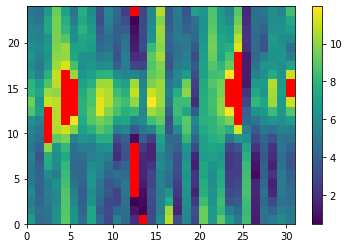

In [13]:
palette = plt.cm.viridis

palette.set_bad('r', 1.0) # outliers en rouge
plt.pcolormesh(np.where(~outliers_temperature_flag, data, np.nan), cmap=palette) # on retire les "outliers"
plt.colorbar()

### Le fancy indexing

Il consiste à indexer des array avec 

- un autre tableau de booléen
- un tableau contenant les indices (qui sera de shape (ndim, dim_1, dim_2... dim_n), (2, dim1, dim2) pour un tableau 2D par exemple).

In [20]:
# avec des booléens
data[neg_temperature_flag]
# avec un tableau d'indice
data[np.where(neg_temperature_flag)]
# En fournissant les x et les y directements
#data[(0, 0, 0), (0, 1, 2)] # équivalent à data[0, :3]

array([-0.19      , -0.40333333, -0.46666667, -0.46333333, -0.08333333])

In [19]:
neg_temp_x, neg_temp_y = np.where(neg_temperature_flag)
print(neg_temp_x)
print(neg_temp_y)

[4 5 6 7 8]
[12 12 12 12 12]


## Broadcasting

Le broadcasting permet de rapidement combiner plusieurs dimension. A savoir qu'une opération entre deux array de dimension différentes mais compatibles sera effectué en *étendant* le tableau dont il manquerai des valeurs.

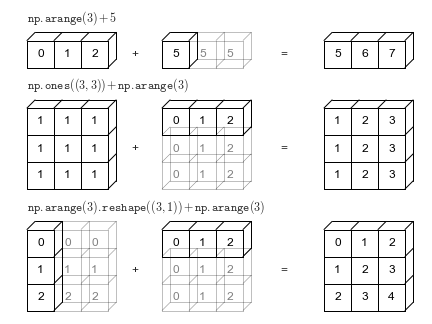

Imaginons que l'on veuille retirer une tendance sinusoidale journalière de nos données de température, qui suivrait la formule suivante :

In [28]:
h = np.arange(24)
ϕ = 10
amplitude = 1.5 * data.std()
T0 = data.mean()
freq = 1 / 24
T_th = T0 + amplitude * np.cos((h + ϕ) * freq * 2 * np.pi)

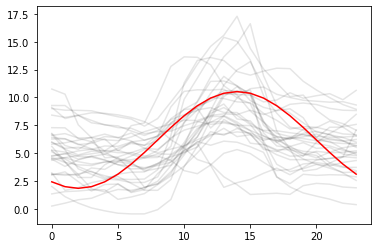

In [29]:
for d_ in data.T:
    plt.plot(h, d_, color="black", alpha=.1)
plt.plot(h, T_th, color="red")

C'est loin d'être parfaitement représentatif de nos donnée mais sera suffisant comme exemple.
Comment retirer d'un coup cette tendance au données de chaques jours?

In [38]:
#data - T_th
print(T_th.reshape((24,1)).shape)
print(T_th.reshape((-1, 1)).shape)
print(data.shape)

(24, 1)
(24, 1)
(24, 31)


En l'état, numpy refuse de travailler avec deux tableaux dont la dernière dimension diffère (ici 31 != 24). Il faut donc transposer data ou **ajouter une dimension à `T_th`**. Il existe plusieur façon de faire.

- `T_th.reshape((24, 1))` ou `T_th.reshape((-1, 1))`, -1 s'ajustant au nombre de valeur du tableau.
- `T_th[:, np.newaxis]`, np.newaxis ajoutant une dimension au tableau (pouvant être remplacé par `T_th[:, None]`).

In [31]:
data_minus_T_th = (T_th - data.T).T # va marcher, mais demande deux transposés
data_minus_T_th = T_th.reshape((-1, 1)) - data
data_minus_T_th = T_th[:, np.newaxis] - data # même chose que data_minus_T_th = T_th[:, None] - data

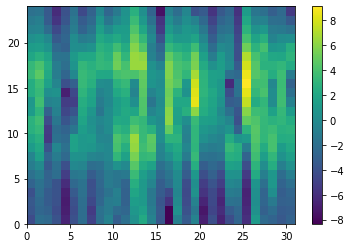

In [33]:
plt.pcolormesh(data_minus_T_th)
plt.colorbar()